<a href="https://colab.research.google.com/github/kartikey2807/MNIST-with-CNN-1RT720/blob/main/HandInAssignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hand-In Assignment 1
* **Exercise 1**
* implement fully connected network
* Use Pytorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset

* Initialize model
* Same as Assignment 1

In [3]:
class Network(nn.Module):
    def __init__(self, hidden_layers, hidden_dim, input_dim=784, output_dim=10): ## 784 = 28x28, 10 digits
        super(Network,self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim,hidden_dim[0]))
        self.layers.append(nn.ReLU())

        for i in range(1,hidden_layers):
            self.layers.append(nn.Linear(hidden_dim[i-1],hidden_dim[i])) ## hidden
            self.layers.append(nn.ReLU())

        self.layers.append(nn.Linear(hidden_dim[hidden_layers-1],output_dim))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return x ## logits. REMEMBER NOT TO APPLY SOFTMAX ON THE OUTPUT. APPLIED WHEN USING CROSS ENTROPY


* set device

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

* load data

In [5]:
## TRAIN
class MNISTTrain(Dataset):
    def __init__(self, isCNN = False):

        super(MNISTTrain,self).__init__()
        self.x = np.loadtxt('/content/X_train.csv',delimiter=',',dtype=np.float32,skiprows=1)## 784
        self.y = np.loadtxt('/content/Y_train.csv',delimiter=',',dtype=np.float32,skiprows=1)## 10 labels

        self.x = torch.from_numpy(self.x[:,1:])
        self.y = torch.from_numpy(self.y[:,1:])

        if isCNN:
            self.x = torch.reshape(self.x, (len(self.x),1,28,28))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index,:], self.y[index,:]

## VALID
class MNISTValid(Dataset):
    def __init__(self, isCNN = False):

        super(MNISTValid,self).__init__()
        self.x = np.loadtxt('/content/X_test.csv',delimiter=',',dtype=np.float32,skiprows=1) ## 784
        self.y = np.loadtxt('/content/Y_test.csv',delimiter=',',dtype=np.float32,skiprows=1) ## 10 labels

        self.x = torch.from_numpy(self.x[:,1:])
        self.y = torch.from_numpy(self.y[:,1:])

        if isCNN:
            self.x = torch.reshape(self.x, (len(self.x),1,28,28))## FOR CNN CASE

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index,:], self.y[index,:]

* Hidden layers = 2
* Hidden neurons = [125,50]
* Input dimensions = 784
* Output dimensions = 10
---
* learning rate = 0.005
* epochs = 100
* batch size = 64 [random selection]

In [6]:
## HYPERPARAMETERS
hidden_layers = 2
hidden_dim = [125,50]
input_dim = 784
output_dim = 10

learning_rate = 0.005
epochs = 20 ## 100
batch_size = 64

In [7]:
validdataset = MNISTValid()
traindataset = MNISTTrain()
trainloader = DataLoader(traindataset,batch_size=batch_size,shuffle=True)

In [8]:
x,y = validdataset[:] ## NO POINT IN MAKING IT batch
print(x.shape)
print(y.shape)

torch.Size([10000, 784])
torch.Size([10000, 10])


* Initialize Network
* Train

In [9]:
model = Network(hidden_layers=hidden_layers,
                hidden_dim=hidden_dim,
                input_dim=input_dim,
                output_dim=output_dim).to(device=device) ## CUDA

loss = nn.CrossEntropyLoss()
soft = nn.Softmax(dim=1)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate) ## ADAM is good for mini-batch descent

In [10]:
summary(model,input_size=(1,input_dim),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [64, 1, 125]          98,125
              ReLU-2               [64, 1, 125]               0
            Linear-3                [64, 1, 50]           6,300
              ReLU-4                [64, 1, 50]               0
            Linear-5                [64, 1, 10]             510
Total params: 104,935
Trainable params: 104,935
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.18
Params size (MB): 0.40
Estimated Total Size (MB): 0.77
----------------------------------------------------------------


In [11]:
def compute_stats(model, dataset):

    with torch.no_grad(): ## NO GRADIENTS
        x, y = dataset[:]
        x = x.to(device=device)
        y = y.to(device=device)

        slogits = model(x)
        sloss = loss(slogits,y)

        t1 = torch.argmax(soft(slogits),dim=1)
        t2 = torch.argmax(soft(y),dim=1)
        saccuracy = (torch.sum(t1==t2)/len(dataset))*100
    return sloss, saccuracy

In [12]:
def model_fit(epochs, trainloader, traindataset, validdataset, model, loss, optimizer):
    train_loss, valid_loss = [], []
    train_accu, valid_accu = [], []

    ## Train network
    for epoch in range(epochs):
        print(f'Epoch: {epoch+1}/{epochs}') ## FANCYYYYY OUTPUT
        for batch, (x,y) in enumerate(trainloader):
            x = x.to(device=device)
            y = y.to(device=device)

            ## forward pass
            logits = model(x)
            loss_value = loss(logits,y)

            ## backward pass
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

        ## MODEL EVAL
        model.eval()

        ## store train loss and accuracy
        tloss,taccu = compute_stats(model,dataset=traindataset)
        train_loss.append(tloss.numpy(force=True))
        train_accu.append(taccu.numpy(force=True))

        ## store valid loss and accuracy
        vloss,vaccu = compute_stats(model,dataset=validdataset)
        valid_loss.append(vloss.numpy(force=True))
        valid_accu.append(vaccu.numpy(force=True))

        print(f'''Train Loss: {tloss:.2f} | Test Loss: {vloss:.2f} \
        Train Accuracy%: {taccu:.2f} | Test Accuracy%: {vaccu:.2f}''')
        ## MODEL TRAIN
        model.train()

    return train_accu, valid_accu, train_loss, valid_loss

In [13]:
train_accu, valid_accu, train_loss, valid_loss = model_fit(epochs,trainloader,traindataset,validdataset,
                                                           model,loss,optimizer)

Epoch: 1/20
Train Loss: 0.11 | Test Loss: 0.12         Train Accuracy%: 96.66 | Test Accuracy%: 95.98
Epoch: 2/20
Train Loss: 0.07 | Test Loss: 0.10         Train Accuracy%: 97.74 | Test Accuracy%: 96.99
Epoch: 3/20
Train Loss: 0.08 | Test Loss: 0.12         Train Accuracy%: 97.62 | Test Accuracy%: 96.83
Epoch: 4/20
Train Loss: 0.06 | Test Loss: 0.11         Train Accuracy%: 98.01 | Test Accuracy%: 96.95
Epoch: 5/20
Train Loss: 0.06 | Test Loss: 0.12         Train Accuracy%: 98.17 | Test Accuracy%: 96.87
Epoch: 6/20
Train Loss: 0.04 | Test Loss: 0.11         Train Accuracy%: 98.54 | Test Accuracy%: 96.96
Epoch: 7/20
Train Loss: 0.05 | Test Loss: 0.12         Train Accuracy%: 98.58 | Test Accuracy%: 97.00
Epoch: 8/20
Train Loss: 0.03 | Test Loss: 0.11         Train Accuracy%: 98.97 | Test Accuracy%: 97.41
Epoch: 9/20
Train Loss: 0.03 | Test Loss: 0.11         Train Accuracy%: 99.19 | Test Accuracy%: 97.70
Epoch: 10/20
Train Loss: 0.03 | Test Loss: 0.13         Train Accuracy%: 99.18 | T

* Got more or less the same results as in assignment 1   
* Approx 98%

In [14]:
def model_plot(train_accu, valid_accu, train_loss, valid_loss, optimizer):
    fig,axes = plt.subplots(1, 2, figsize = (15,5))
    fig.suptitle(f'| Batch Size: {batch_size} | Learning Rate: {learning_rate} | Epochs: {epochs} | Optimizer: {optimizer} |')
    axes[0].plot(train_loss,label='Train Loss')
    axes[0].plot(valid_loss,label='Valid Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Cost')
    axes[0].set_title('Cost vs Epochs')
    axes[0].legend()
    axes[0].grid()

    axes[1].plot(train_accu,label='Train Accuracy')
    axes[1].plot(valid_accu,label='Valid Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy%')
    axes[1].set_title('Accuracy% vs Epochs')
    axes[1].legend()
    axes[1].grid()

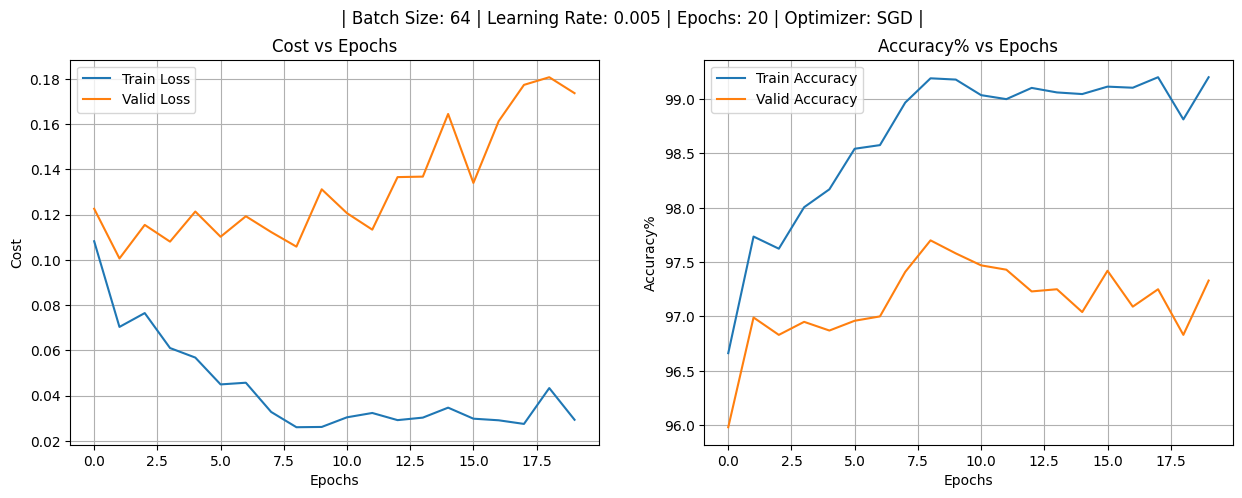

In [15]:
model_plot(train_accu,valid_accu,train_loss,valid_loss,optimizer='SGD')

---
* **Exercise 2**
* Replace fully connected network with CNN

In [16]:
## INITIALIZE NETWORK
class CNN(nn.Module):
    def __init__(self, input_channels, output_dim, kernel_size, stride, padding):
        super(CNN,self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(input_channels)-1):
            self.layers.append(nn.Conv2d(in_channels=input_channels[i], out_channels=input_channels[i+1],
                                         kernel_size=kernel_size,stride=stride,padding=padding))
            self.layers.append(nn.ReLU())
            if i < len(input_channels)-2:
                self.layers.append(nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)))

        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(in_features=input_channels[-1]*7*7,out_features=output_dim))

        ## NO POINT ADDING SOFTMAX IF I AM GOING TO APPLY CROSSENTROPY LOSS

    def forward(self, x):

        for layer in self.layers: ## RUNNING THROUGH EACH LAYER. GET LOGITS
            x = layer(x)
        return x

In [17]:
## HYPERPARAMETERS
input_channels = [1,8,16,32]
input_dim = [28,28]
output_dim = 10
kernel_size = (3,3)
stride = (1,1)
padding = (1,1)

batch_size = 128
learning_rate = 0.01
epochs = 20

In [18]:
## DEFINE MODEL
model = CNN(input_channels=input_channels,output_dim=output_dim,kernel_size=kernel_size,stride=stride,
            padding=padding).to(device=device)

## DEFINE OPTIMIZER
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

In [19]:
summary(model,input_size=(input_channels[0],input_dim[0],input_dim[1]),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 8, 28, 28]              80
              ReLU-2           [128, 8, 28, 28]               0
         MaxPool2d-3           [128, 8, 14, 14]               0
            Conv2d-4          [128, 16, 14, 14]           1,168
              ReLU-5          [128, 16, 14, 14]               0
         MaxPool2d-6            [128, 16, 7, 7]               0
            Conv2d-7            [128, 32, 7, 7]           4,640
              ReLU-8            [128, 32, 7, 7]               0
           Flatten-9                [128, 1568]               0
           Linear-10                  [128, 10]          15,690
Total params: 21,578
Trainable params: 21,578
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 25.28
Params size (MB): 0.08
Estimated To

**Trainable Parameters for Fully connected network**:
104,935   
**Trainable Parameters for CNN**: 21,578

In [20]:
## LOAD DATA
traindataset = MNISTTrain(isCNN=True)
validdataset = MNISTValid(isCNN=True)
trainloader = DataLoader(traindataset,batch_size=batch_size,shuffle=True)

In [21]:
x,y = traindataset[:]
print(x.shape)
print(y.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000, 10])


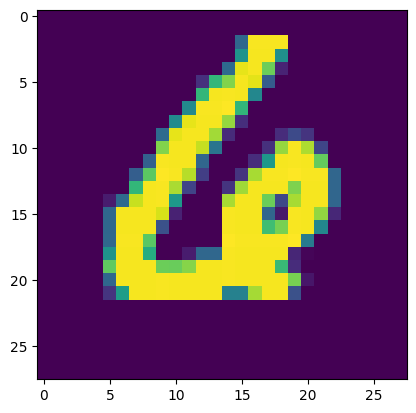

In [22]:
plt.imshow(x[40000,0])

In [23]:
## TRAIN
loss = nn.CrossEntropyLoss()
soft = nn.Softmax(dim=1)
train_accu, valid_accu, train_loss, valid_loss = model_fit(epochs,trainloader,traindataset,validdataset,
                                                           model,loss,optimizer)

Epoch: 1/20
Train Loss: 2.19 | Test Loss: 2.19         Train Accuracy%: 53.83 | Test Accuracy%: 54.16
Epoch: 2/20
Train Loss: 0.43 | Test Loss: 0.42         Train Accuracy%: 87.00 | Test Accuracy%: 87.15
Epoch: 3/20
Train Loss: 0.36 | Test Loss: 0.34         Train Accuracy%: 88.65 | Test Accuracy%: 89.33
Epoch: 4/20
Train Loss: 0.26 | Test Loss: 0.25         Train Accuracy%: 92.07 | Test Accuracy%: 92.45
Epoch: 5/20
Train Loss: 0.24 | Test Loss: 0.23         Train Accuracy%: 92.88 | Test Accuracy%: 93.25
Epoch: 6/20
Train Loss: 0.20 | Test Loss: 0.19         Train Accuracy%: 93.96 | Test Accuracy%: 94.11
Epoch: 7/20
Train Loss: 0.16 | Test Loss: 0.15         Train Accuracy%: 95.42 | Test Accuracy%: 95.61
Epoch: 8/20
Train Loss: 0.13 | Test Loss: 0.12         Train Accuracy%: 96.10 | Test Accuracy%: 96.13
Epoch: 9/20
Train Loss: 0.11 | Test Loss: 0.10         Train Accuracy%: 96.64 | Test Accuracy%: 96.67
Epoch: 10/20
Train Loss: 0.11 | Test Loss: 0.10         Train Accuracy%: 96.83 | T

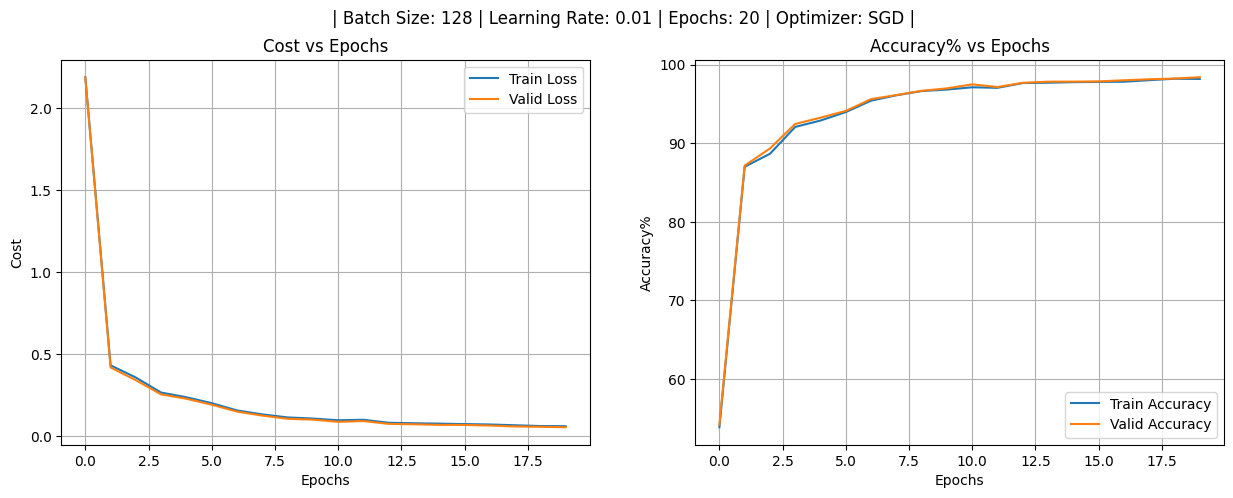

In [24]:
model_plot(train_accu,valid_accu,train_loss,valid_loss,optimizer='SGD')

---
* **Exercise 3**
* Swap ReLU and MaxPooling Layers

In [25]:
## INITIALIZE NETWORK
class CNNSwap(nn.Module):
    def __init__(self, input_channels, output_dim, kernel_size, stride, padding):
        super(CNNSwap,self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(input_channels)-1):
            self.layers.append(nn.Conv2d(in_channels=input_channels[i],out_channels=input_channels[i+1],
                                         kernel_size=kernel_size,stride=stride,padding=padding))
            if i < len(input_channels)-2:
                self.layers.append(nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)))

            self.layers.append(nn.ReLU()) ## SWAPPED

        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(in_features=input_channels[-1]*7*7,out_features=output_dim))

    def forward(self, x):

        for layer in self.layers: ## RUNNING THROUGH EACH LAYER. GET LOGITS
            x = layer(x)
        return x

In [26]:
model = CNNSwap(input_channels=input_channels,output_dim=output_dim,kernel_size=kernel_size,stride=stride,
            padding=padding).to(device=device)

In [27]:
summary(model,input_size=(input_channels[0],input_dim[0],input_dim[1]),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 8, 28, 28]              80
         MaxPool2d-2           [128, 8, 14, 14]               0
              ReLU-3           [128, 8, 14, 14]               0
            Conv2d-4          [128, 16, 14, 14]           1,168
         MaxPool2d-5            [128, 16, 7, 7]               0
              ReLU-6            [128, 16, 7, 7]               0
            Conv2d-7            [128, 32, 7, 7]           4,640
              ReLU-8            [128, 32, 7, 7]               0
           Flatten-9                [128, 1568]               0
           Linear-10                  [128, 10]          15,690
Total params: 21,578
Trainable params: 21,578
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 18.38
Params size (MB): 0.08
Estimated To

In [28]:
train_accu, valid_accu, train_loss, valid_loss = model_fit(epochs,trainloader,traindataset,validdataset,
                                                           model,loss,optimizer)

Epoch: 1/20
Train Loss: 2.30 | Test Loss: 2.30         Train Accuracy%: 9.92 | Test Accuracy%: 10.10
Epoch: 2/20
Train Loss: 2.30 | Test Loss: 2.30         Train Accuracy%: 9.92 | Test Accuracy%: 10.10
Epoch: 3/20
Train Loss: 2.30 | Test Loss: 2.30         Train Accuracy%: 9.92 | Test Accuracy%: 10.10
Epoch: 4/20
Train Loss: 2.30 | Test Loss: 2.30         Train Accuracy%: 9.92 | Test Accuracy%: 10.10
Epoch: 5/20
Train Loss: 2.30 | Test Loss: 2.30         Train Accuracy%: 9.92 | Test Accuracy%: 10.10
Epoch: 6/20
Train Loss: 2.30 | Test Loss: 2.30         Train Accuracy%: 9.92 | Test Accuracy%: 10.10
Epoch: 7/20
Train Loss: 2.30 | Test Loss: 2.30         Train Accuracy%: 9.92 | Test Accuracy%: 10.10
Epoch: 8/20
Train Loss: 2.30 | Test Loss: 2.30         Train Accuracy%: 9.92 | Test Accuracy%: 10.10
Epoch: 9/20
Train Loss: 2.30 | Test Loss: 2.30         Train Accuracy%: 9.92 | Test Accuracy%: 10.10
Epoch: 10/20
Train Loss: 2.30 | Test Loss: 2.30         Train Accuracy%: 9.92 | Test Accura

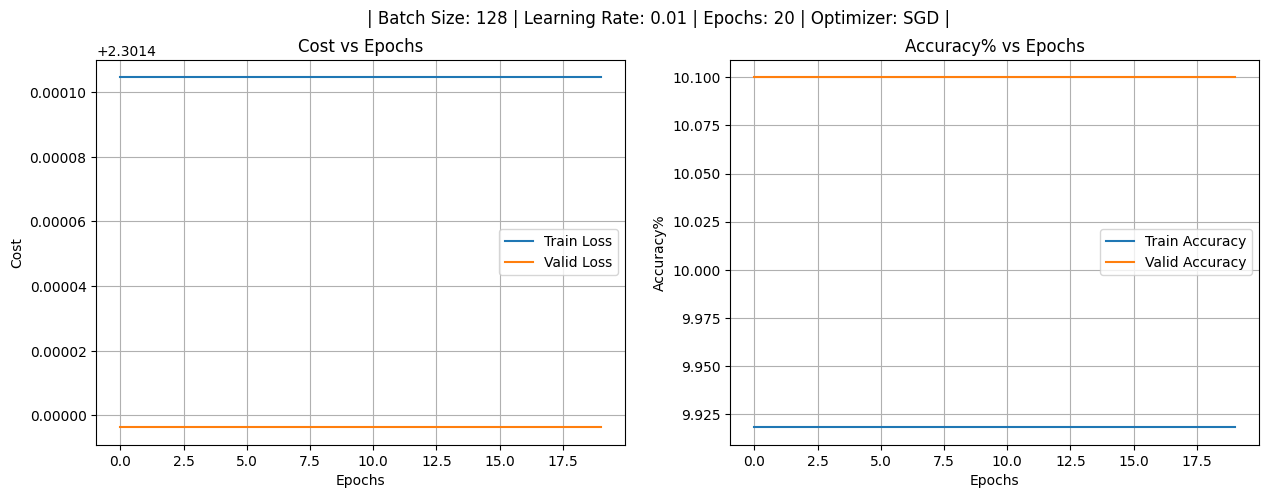

In [29]:
model_plot(train_accu,valid_accu,train_loss,valid_loss,optimizer='SGD')

* Bruh!! The model is sooo bad now.
* Replace ReLU with Hyperbolic Tangent

In [30]:
## INITIALIZE NETWORK
class CNNHyperbolic(nn.Module):
    def __init__(self, input_channels, output_dim, kernel_size, stride, padding):
        super(CNNHyperbolic,self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(input_channels)-1):
            self.layers.append(nn.Conv2d(in_channels=input_channels[i], out_channels=input_channels[i+1],
                                         kernel_size=kernel_size,stride=stride,padding=padding))
            if i < len(input_channels)-2:
                self.layers.append(nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)))

            self.layers.append(nn.Tanh()) ## SWAPPED
        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(in_features=input_channels[-1]*7*7,out_features=output_dim))

    def forward(self, x):

        for layer in self.layers: ## RUNNING THROUGH EACH LAYER. GET LOGITS
            x = layer(x)
        return x

In [31]:
model = CNNHyperbolic(input_channels=input_channels,output_dim=output_dim,kernel_size=kernel_size,
                      stride=stride,padding=padding).to(device=device)

In [32]:
summary(model,input_size=(input_channels[0],input_dim[0],input_dim[1]),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 8, 28, 28]              80
         MaxPool2d-2           [128, 8, 14, 14]               0
              Tanh-3           [128, 8, 14, 14]               0
            Conv2d-4          [128, 16, 14, 14]           1,168
         MaxPool2d-5            [128, 16, 7, 7]               0
              Tanh-6            [128, 16, 7, 7]               0
            Conv2d-7            [128, 32, 7, 7]           4,640
              Tanh-8            [128, 32, 7, 7]               0
           Flatten-9                [128, 1568]               0
           Linear-10                  [128, 10]          15,690
Total params: 21,578
Trainable params: 21,578
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 18.38
Params size (MB): 0.08
Estimated To

In [33]:
train_accu, valid_accu, train_loss, valid_loss = model_fit(epochs,trainloader,traindataset,validdataset,
                                                           model,loss,optimizer)

Epoch: 1/20
Train Loss: 2.30 | Test Loss: 2.30         Train Accuracy%: 9.85 | Test Accuracy%: 9.57
Epoch: 2/20
Train Loss: 2.30 | Test Loss: 2.30         Train Accuracy%: 9.85 | Test Accuracy%: 9.57
Epoch: 3/20
Train Loss: 2.30 | Test Loss: 2.30         Train Accuracy%: 9.85 | Test Accuracy%: 9.57
Epoch: 4/20
Train Loss: 2.30 | Test Loss: 2.30         Train Accuracy%: 9.85 | Test Accuracy%: 9.57
Epoch: 5/20
Train Loss: 2.30 | Test Loss: 2.30         Train Accuracy%: 9.85 | Test Accuracy%: 9.57
Epoch: 6/20
Train Loss: 2.30 | Test Loss: 2.30         Train Accuracy%: 9.85 | Test Accuracy%: 9.57
Epoch: 7/20
Train Loss: 2.30 | Test Loss: 2.30         Train Accuracy%: 9.85 | Test Accuracy%: 9.57
Epoch: 8/20
Train Loss: 2.30 | Test Loss: 2.30         Train Accuracy%: 9.85 | Test Accuracy%: 9.57
Epoch: 9/20
Train Loss: 2.30 | Test Loss: 2.30         Train Accuracy%: 9.85 | Test Accuracy%: 9.57
Epoch: 10/20
Train Loss: 2.30 | Test Loss: 2.30         Train Accuracy%: 9.85 | Test Accuracy%: 9.57

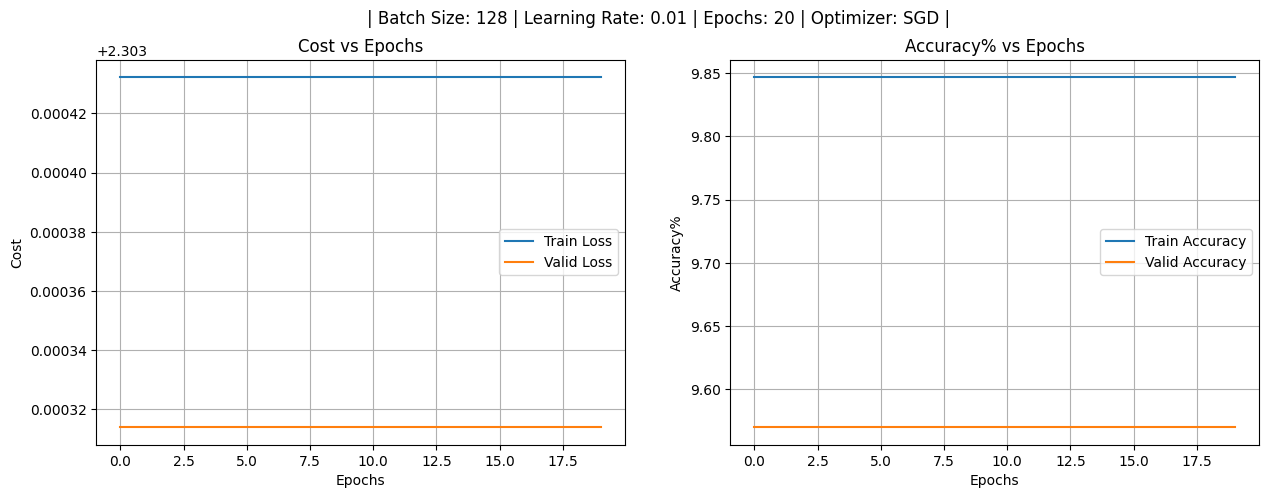

In [34]:
model_plot(train_accu,valid_accu,train_loss,valid_loss,optimizer='SGD')

* **Exercise 4**
* Use Adam instead of SGD

In [35]:
model = CNN(input_channels=input_channels,output_dim=output_dim,kernel_size=kernel_size,stride=stride,
            padding=padding).to(device=device)
## ADAM
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [36]:
summary(model,input_size=(input_channels[0],input_dim[0],input_dim[1]),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 8, 28, 28]              80
              ReLU-2           [128, 8, 28, 28]               0
         MaxPool2d-3           [128, 8, 14, 14]               0
            Conv2d-4          [128, 16, 14, 14]           1,168
              ReLU-5          [128, 16, 14, 14]               0
         MaxPool2d-6            [128, 16, 7, 7]               0
            Conv2d-7            [128, 32, 7, 7]           4,640
              ReLU-8            [128, 32, 7, 7]               0
           Flatten-9                [128, 1568]               0
           Linear-10                  [128, 10]          15,690
Total params: 21,578
Trainable params: 21,578
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 25.28
Params size (MB): 0.08
Estimated To

In [37]:
train_accu, valid_accu, train_loss, valid_loss = model_fit(epochs,trainloader,traindataset,validdataset,
                                                           model,loss,optimizer)

Epoch: 1/20
Train Loss: 0.06 | Test Loss: 0.06         Train Accuracy%: 98.07 | Test Accuracy%: 98.06
Epoch: 2/20
Train Loss: 0.05 | Test Loss: 0.07         Train Accuracy%: 98.30 | Test Accuracy%: 98.07
Epoch: 3/20
Train Loss: 0.04 | Test Loss: 0.05         Train Accuracy%: 98.71 | Test Accuracy%: 98.57
Epoch: 4/20
Train Loss: 0.05 | Test Loss: 0.06         Train Accuracy%: 98.44 | Test Accuracy%: 98.21
Epoch: 5/20
Train Loss: 0.03 | Test Loss: 0.05         Train Accuracy%: 99.15 | Test Accuracy%: 98.44
Epoch: 6/20
Train Loss: 0.03 | Test Loss: 0.06         Train Accuracy%: 98.91 | Test Accuracy%: 98.01
Epoch: 7/20
Train Loss: 0.02 | Test Loss: 0.06         Train Accuracy%: 99.23 | Test Accuracy%: 98.46
Epoch: 8/20
Train Loss: 0.03 | Test Loss: 0.06         Train Accuracy%: 98.94 | Test Accuracy%: 98.38
Epoch: 9/20
Train Loss: 0.03 | Test Loss: 0.07         Train Accuracy%: 99.04 | Test Accuracy%: 98.13
Epoch: 10/20
Train Loss: 0.02 | Test Loss: 0.06         Train Accuracy%: 99.17 | T

* Close to 99%

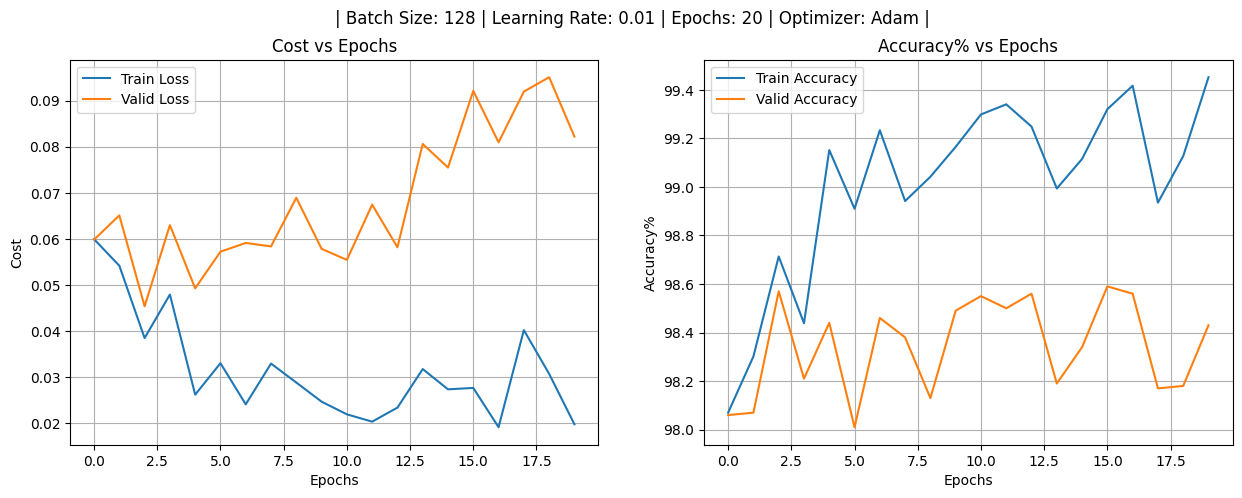

In [38]:
model_plot(train_accu,valid_accu,train_loss,valid_loss,optimizer='Adam')

---
* **Exercise 5**
* Use of residual connections

In [39]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ResidualBlock,self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=kernel_size,stride=stride,
                               padding=padding)
        self.conv2 = nn.Conv2d(in_channels=out_channels,
                               out_channels=out_channels,
                               kernel_size=kernel_size,stride=stride,
                               padding=padding)
        self.relu  = nn.ReLU()
        self.skip  = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size = (1,1),stride=stride,padding=(0,0))

    def forward(self, x):
        identity = x
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        identity = self.relu(self.skip(identity)) ## SKIP CONNECTION ADDED HERE
        x = x + identity
        return x

In [40]:
class ResNN(nn.Module):
    def __init__(self, input_channels, output_dim, kernel_size, stride, padding): ## Residual Networks
        super(ResNN,self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(ResidualBlock(in_channels=input_channels[0],out_channels=input_channels[1],
                                         kernel_size=kernel_size,stride=stride,padding=padding))
        self.layers.append(nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)))
        self.layers.append(ResidualBlock(in_channels=input_channels[1],out_channels=input_channels[2],
                                         kernel_size=kernel_size,stride=stride,padding=padding))
        self.layers.append(nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)))
        self.layers.append(ResidualBlock(in_channels=input_channels[2],out_channels=input_channels[3],
                                         kernel_size=kernel_size,stride=stride,padding=padding))
        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(in_features=input_channels[-1]*7*7,out_features=output_dim))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x ## logits

In [41]:
## HYPERPARAMETERS
input_channels = [1,8,16,32]
input_dim = [28,28]
output_dim = 10
kernel_size = (3,3)
stride = (1,1)
padding = (1,1)

batch_size = 128
learning_rate = 0.01
epochs = 20

In [42]:
model = ResNN(input_channels=input_channels,output_dim=output_dim,kernel_size=kernel_size,stride=stride,
              padding=padding).to(device=device)

In [43]:
summary(model,input_size=(input_channels[0],input_dim[0],input_dim[1]),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 8, 28, 28]              80
              ReLU-2           [128, 8, 28, 28]               0
            Conv2d-3           [128, 8, 28, 28]             584
              ReLU-4           [128, 8, 28, 28]               0
            Conv2d-5           [128, 8, 28, 28]              16
              ReLU-6           [128, 8, 28, 28]               0
     ResidualBlock-7           [128, 8, 28, 28]               0
         MaxPool2d-8           [128, 8, 14, 14]               0
            Conv2d-9          [128, 16, 14, 14]           1,168
             ReLU-10          [128, 16, 14, 14]               0
           Conv2d-11          [128, 16, 14, 14]           2,320
             ReLU-12          [128, 16, 14, 14]               0
           Conv2d-13          [128, 16, 14, 14]             144
             ReLU-14          [128, 16,

In [44]:
loss = nn.CrossEntropyLoss()
soft = nn.Softmax(dim=1)

In [45]:
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
train_accu, valid_accu, train_loss, valid_loss = model_fit(epochs,trainloader,traindataset,validdataset,
                                                           model,loss,optimizer)

Epoch: 1/20
Train Loss: 0.11 | Test Loss: 0.11         Train Accuracy%: 96.48 | Test Accuracy%: 96.63
Epoch: 2/20
Train Loss: 0.09 | Test Loss: 0.08         Train Accuracy%: 97.45 | Test Accuracy%: 97.56
Epoch: 3/20
Train Loss: 0.07 | Test Loss: 0.07         Train Accuracy%: 98.03 | Test Accuracy%: 98.08
Epoch: 4/20
Train Loss: 0.04 | Test Loss: 0.04         Train Accuracy%: 98.71 | Test Accuracy%: 98.50
Epoch: 5/20
Train Loss: 0.05 | Test Loss: 0.05         Train Accuracy%: 98.64 | Test Accuracy%: 98.57
Epoch: 6/20
Train Loss: 0.04 | Test Loss: 0.05         Train Accuracy%: 98.78 | Test Accuracy%: 98.38
Epoch: 7/20
Train Loss: 0.04 | Test Loss: 0.05         Train Accuracy%: 98.65 | Test Accuracy%: 98.58
Epoch: 8/20
Train Loss: 0.04 | Test Loss: 0.04         Train Accuracy%: 98.87 | Test Accuracy%: 98.59
Epoch: 9/20
Train Loss: 0.04 | Test Loss: 0.05         Train Accuracy%: 98.66 | Test Accuracy%: 98.39
Epoch: 10/20
Train Loss: 0.05 | Test Loss: 0.06         Train Accuracy%: 98.36 | T

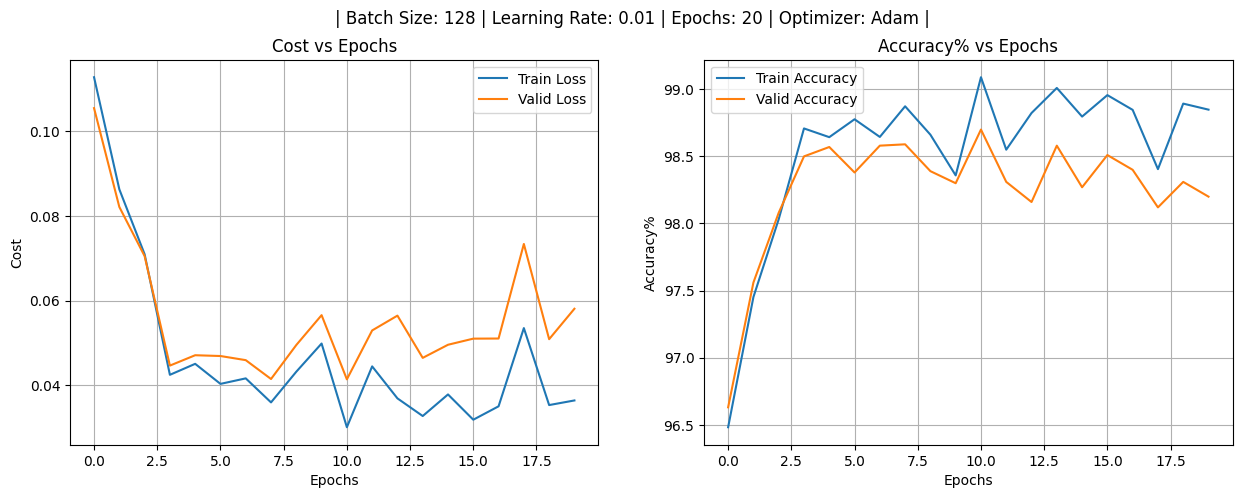

In [46]:
model_plot(train_accu,valid_accu,train_loss,valid_loss,optimizer='Adam')

---
* **Exercise 6**
* Variations
* Batch Normalization
* Dropout Layer
* optimizer - RMSProp

In [47]:
## VARIATION 1
class ResidualBlockBN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ResidualBlockBN,self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=kernel_size,stride=stride,
                               padding=padding)
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(in_channels=out_channels,
                               out_channels=out_channels,
                               kernel_size=kernel_size,stride=stride,
                               padding=padding)
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU()
        self.skip  = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=(1,1),stride=(1,1),padding=(0,0))
        self.norm3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        identity = x
        x = self.relu(self.norm1(self.conv1(x)))
        x = self.relu(self.norm2(self.conv2(x)))

        identity = self.relu(self.norm3(self.skip(identity))) ## SKIP CONNECTIONs ADDED HERE
        x = x + identity
        return x

class ResNNBN(nn.Module):
    def __init__(self, input_channels, output_dim, kernel_size, stride, padding, dropout=False):
        super(ResNNBN,self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(ResidualBlockBN(in_channels=input_channels[0],out_channels=input_channels[1],
                        kernel_size=kernel_size,stride=stride,padding=padding))
        self.layers.append(nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)))
        self.layers.append(ResidualBlockBN(in_channels=input_channels[1],out_channels=input_channels[2],
                        kernel_size=kernel_size,stride=stride,padding=padding))
        self.layers.append(nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)))
        self.layers.append(ResidualBlockBN(in_channels=input_channels[2],out_channels=input_channels[3],
                        kernel_size=kernel_size,stride=stride,padding=padding))
        self.layers.append(nn.Flatten())

        if dropout:
            self.layers.append(nn.Linear(in_features=input_channels[-1]*7*7,out_features=50))
            self.layers.append(nn.Dropout(p=0.2))
            self.layers.append(nn.Linear(in_features=50,out_features=output_dim))
        else:
            self.layers.append(nn.Linear(in_features=input_channels[-1]*7*7,out_features=output_dim))

    def forward(self, x):

        for layer in self.layers:
            x = layer(x)
        return x ## logits

In [48]:
modelv1 = ResNNBN(input_channels=input_channels,output_dim=output_dim,kernel_size=kernel_size,stride=stride,
                padding=padding).to(device=device)

In [49]:
summary(modelv1,input_size=(input_channels[0],input_dim[0],input_dim[1]),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 8, 28, 28]              80
       BatchNorm2d-2           [128, 8, 28, 28]              16
              ReLU-3           [128, 8, 28, 28]               0
            Conv2d-4           [128, 8, 28, 28]             584
       BatchNorm2d-5           [128, 8, 28, 28]              16
              ReLU-6           [128, 8, 28, 28]               0
            Conv2d-7           [128, 8, 28, 28]              16
       BatchNorm2d-8           [128, 8, 28, 28]              16
              ReLU-9           [128, 8, 28, 28]               0
  ResidualBlockBN-10           [128, 8, 28, 28]               0
        MaxPool2d-11           [128, 8, 14, 14]               0
           Conv2d-12          [128, 16, 14, 14]           1,168
      BatchNorm2d-13          [128, 16, 14, 14]              32
             ReLU-14          [128, 16,

In [50]:
optimizer = torch.optim.Adam(modelv1.parameters(),lr=learning_rate)
train_accu, valid_accu, train_loss, valid_loss = model_fit(epochs,trainloader,traindataset,validdataset,
                                                           modelv1,loss,optimizer)

Epoch: 1/20
Train Loss: 0.07 | Test Loss: 0.07         Train Accuracy%: 97.80 | Test Accuracy%: 97.96
Epoch: 2/20
Train Loss: 0.05 | Test Loss: 0.05         Train Accuracy%: 98.26 | Test Accuracy%: 98.41
Epoch: 3/20
Train Loss: 0.03 | Test Loss: 0.04         Train Accuracy%: 98.93 | Test Accuracy%: 98.90
Epoch: 4/20
Train Loss: 0.03 | Test Loss: 0.04         Train Accuracy%: 99.07 | Test Accuracy%: 98.71
Epoch: 5/20
Train Loss: 0.04 | Test Loss: 0.05         Train Accuracy%: 98.74 | Test Accuracy%: 98.51
Epoch: 6/20
Train Loss: 0.02 | Test Loss: 0.03         Train Accuracy%: 99.40 | Test Accuracy%: 99.11
Epoch: 7/20
Train Loss: 0.02 | Test Loss: 0.03         Train Accuracy%: 99.40 | Test Accuracy%: 99.00
Epoch: 8/20
Train Loss: 0.02 | Test Loss: 0.03         Train Accuracy%: 99.36 | Test Accuracy%: 99.12
Epoch: 9/20
Train Loss: 0.02 | Test Loss: 0.04         Train Accuracy%: 99.18 | Test Accuracy%: 98.85
Epoch: 10/20
Train Loss: 0.02 | Test Loss: 0.04         Train Accuracy%: 99.48 | T

* With BatchNorm getting **accuracy > 99%**🔥

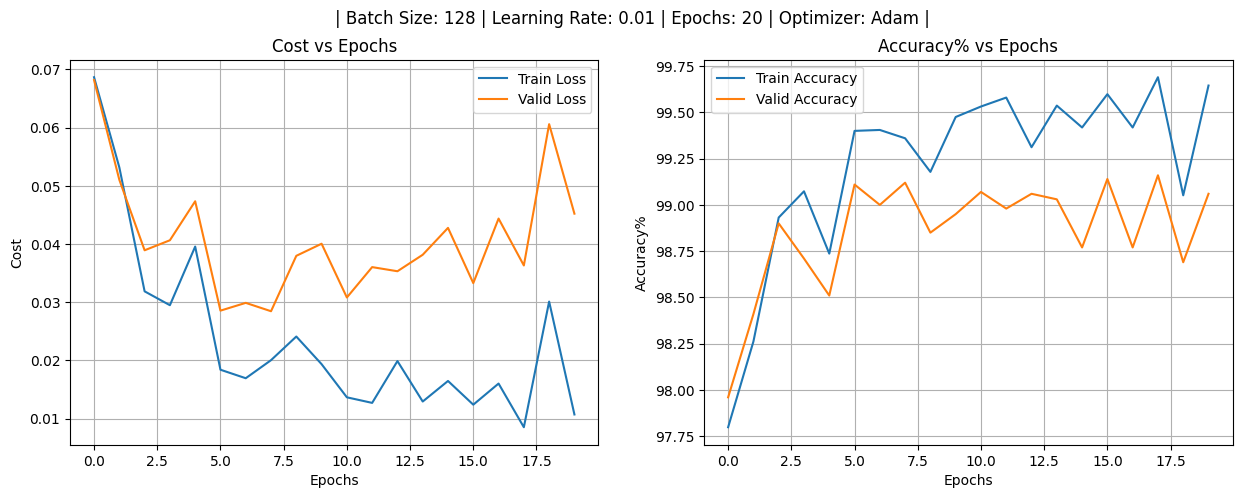

In [51]:
model_plot(train_accu,valid_accu,train_loss,valid_loss,optimizer='Adam')

In [52]:
## VARIATION 2
modelv2 = ResNNBN(input_channels=input_channels,output_dim=output_dim,kernel_size=kernel_size,stride=stride,
                padding=padding,dropout=True).to(device=device)

In [53]:
summary(modelv2,input_size=(input_channels[0],input_dim[0],input_dim[1]),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 8, 28, 28]              80
       BatchNorm2d-2           [128, 8, 28, 28]              16
              ReLU-3           [128, 8, 28, 28]               0
            Conv2d-4           [128, 8, 28, 28]             584
       BatchNorm2d-5           [128, 8, 28, 28]              16
              ReLU-6           [128, 8, 28, 28]               0
            Conv2d-7           [128, 8, 28, 28]              16
       BatchNorm2d-8           [128, 8, 28, 28]              16
              ReLU-9           [128, 8, 28, 28]               0
  ResidualBlockBN-10           [128, 8, 28, 28]               0
        MaxPool2d-11           [128, 8, 14, 14]               0
           Conv2d-12          [128, 16, 14, 14]           1,168
      BatchNorm2d-13          [128, 16, 14, 14]              32
             ReLU-14          [128, 16,

In [54]:
optimizer = torch.optim.Adam(modelv2.parameters(),lr=learning_rate)
train_accu, valid_accu, train_loss, valid_loss = model_fit(epochs,trainloader,traindataset,validdataset,
                                                           modelv2,loss,optimizer)

Epoch: 1/20
Train Loss: 0.08 | Test Loss: 0.07         Train Accuracy%: 97.58 | Test Accuracy%: 97.67
Epoch: 2/20
Train Loss: 0.22 | Test Loss: 0.23         Train Accuracy%: 93.28 | Test Accuracy%: 93.38
Epoch: 3/20
Train Loss: 0.04 | Test Loss: 0.05         Train Accuracy%: 98.78 | Test Accuracy%: 98.51
Epoch: 4/20
Train Loss: 0.04 | Test Loss: 0.05         Train Accuracy%: 98.76 | Test Accuracy%: 98.50
Epoch: 5/20
Train Loss: 0.03 | Test Loss: 0.04         Train Accuracy%: 99.14 | Test Accuracy%: 98.93
Epoch: 6/20
Train Loss: 0.02 | Test Loss: 0.03         Train Accuracy%: 99.26 | Test Accuracy%: 98.99
Epoch: 7/20
Train Loss: 0.03 | Test Loss: 0.04         Train Accuracy%: 99.17 | Test Accuracy%: 98.96
Epoch: 8/20
Train Loss: 0.02 | Test Loss: 0.04         Train Accuracy%: 99.32 | Test Accuracy%: 98.82
Epoch: 9/20
Train Loss: 0.03 | Test Loss: 0.04         Train Accuracy%: 99.14 | Test Accuracy%: 98.87
Epoch: 10/20
Train Loss: 0.04 | Test Loss: 0.06         Train Accuracy%: 98.68 | T

* **accuray = 99.28%** 🔥🔥🔥

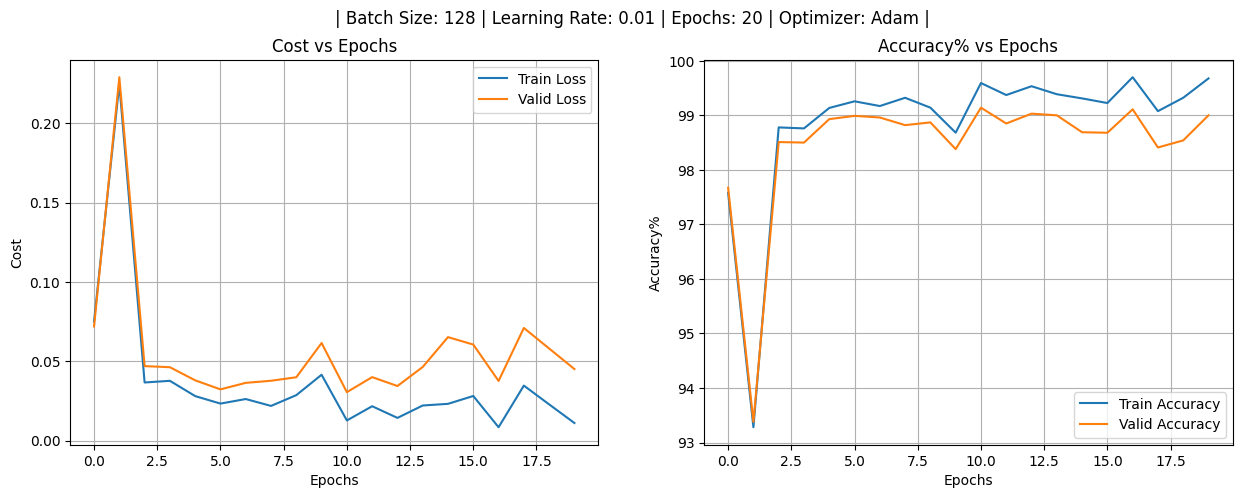

In [55]:
model_plot(train_accu,valid_accu,train_loss,valid_loss,optimizer='Adam')

In [56]:
## HYPERPARAMETERS
input_channels = [1,8,16,32]
input_dim = [28,28]
output_dim = 10
kernel_size = (3,3)
stride = (1,1)
padding = (1,1)

batch_size = 128
learning_rate = 0.01
epochs = 20

In [57]:
## VARIATION 3
modelv3 = ResNNBN(input_channels=input_channels,output_dim=output_dim,kernel_size=kernel_size,stride=stride,
                padding=padding,dropout=True).to(device=device)

In [58]:
optimizer = torch.optim.RMSprop(modelv3.parameters(),lr=learning_rate)
train_accu, valid_accu, train_loss, valid_loss = model_fit(epochs,trainloader,traindataset,validdataset,
                                                           modelv3,loss,optimizer)

Epoch: 1/20
Train Loss: 0.07 | Test Loss: 0.07         Train Accuracy%: 97.67 | Test Accuracy%: 97.77
Epoch: 2/20
Train Loss: 0.09 | Test Loss: 0.09         Train Accuracy%: 97.28 | Test Accuracy%: 97.25
Epoch: 3/20
Train Loss: 0.05 | Test Loss: 0.05         Train Accuracy%: 98.38 | Test Accuracy%: 98.26
Epoch: 4/20
Train Loss: 0.03 | Test Loss: 0.03         Train Accuracy%: 99.02 | Test Accuracy%: 98.82
Epoch: 5/20
Train Loss: 0.12 | Test Loss: 0.11         Train Accuracy%: 96.57 | Test Accuracy%: 96.71
Epoch: 6/20
Train Loss: 0.03 | Test Loss: 0.04         Train Accuracy%: 99.13 | Test Accuracy%: 98.94
Epoch: 7/20
Train Loss: 0.02 | Test Loss: 0.04         Train Accuracy%: 99.28 | Test Accuracy%: 98.92
Epoch: 8/20
Train Loss: 0.04 | Test Loss: 0.05         Train Accuracy%: 98.80 | Test Accuracy%: 98.49
Epoch: 9/20
Train Loss: 0.02 | Test Loss: 0.03         Train Accuracy%: 99.33 | Test Accuracy%: 98.98
Epoch: 10/20
Train Loss: 0.03 | Test Loss: 0.04         Train Accuracy%: 99.22 | T

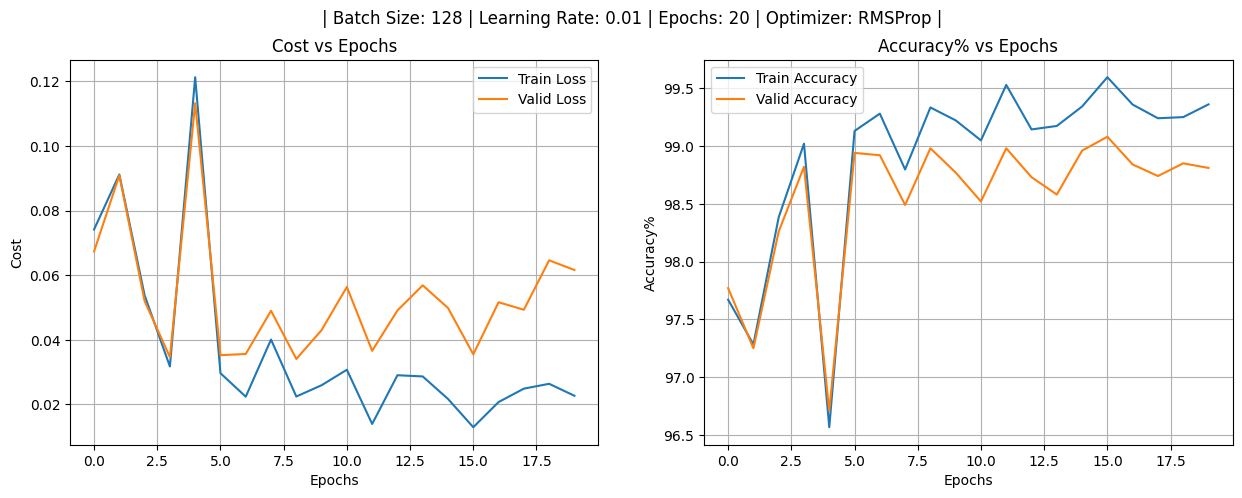

In [59]:
model_plot(train_accu,valid_accu,train_loss,valid_loss,optimizer='RMSProp')

Clearly the best model is **Variation 2**

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

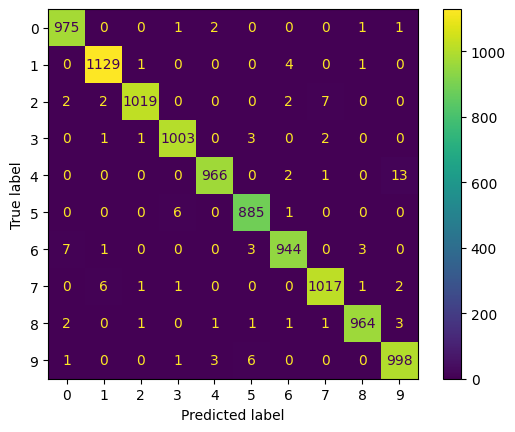

In [66]:
## MODEL EVAL
modelv2.eval()
with torch.no_grad():

    x,y = validdataset[:] ## validation
    x = x.to(device=device)
    y = y.to(device=device)

    logits = soft(modelv2(x))
    cm = confusion_matrix(torch.argmax(y,dim=1).cpu(),torch.argmax(logits,dim=1).cpu())
    ConfusionMatrixDisplay(cm).plot()

**END**
---